# Task 8 - Find the best Random Forest through Random Search

In order to **maximize the performance of the random forest**, we can perform a **random search** for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values (read best model with hyperparameters) that perform the best. 

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

## Random Forest Theory revisited

### Random Forest = Decision Tree + Bagging + Random subsets of features

The Random Forest is a model made up of many `decision trees`. Rather than just simply averaging the prediction of trees (which we could call a **forest**), this model uses two key concepts that gives it the name random:
- Random sampling of training data points when building trees
- Random subsets of features considered when splitting nodes

To be more clear, this takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance. 

Each tree is trained on a random set of the observations, and for each split of a node, only a `subset of the features` are used for making a split. When making predictions, the random forest `averages the predictions` for each of the individual decision trees for each data point in order to arrive at a final classification.

### Bagging

### Random sampling of training observations

- **Training**: each tree in a random forest learns from a **random sample** of the data points. The samples are drawn with replacement, known as **bootstrapping**, which means that some samples will be used multiple times in a single tree. The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

- **Testing**: predictions are made by **averaging the predictions** of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as **bagging**, short for **bootstrap aggregating**.

### Random Subsets of features for splitting nodes
Only a subset of all the features are considered for splitting each node in each decision tree. Generally this is set to `sqrt(n_features)` for classification meaning that if there are 16 features, at each node in each tree, only 4 random features will be considered for splitting the node. 

### Let us see if our theory holds good in the same dataset we used for building Decision Tree

# Behavioral Risk Factor Surveillance System

[Behavioral Risk Factor Surveillance System](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The objective of the BRFSS is to collect uniform, state-specific data on preventive health practices and risk behaviors that are linked to chronic diseases, injuries, and preventable infectious diseases in the adult population. Factors assessed by the BRFSS include tobacco use, health care coverage, HIV/AIDS knowledge or prevention, physical activity, and fruit and vegetable consumption. Data are collected from a random sample of adults (one per household) through a telephone survey.

The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training.

Or, if you have the gut to take it, please pass the entire data and have fun!!!

This problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem. **Why????**

## Data Acquisition
Go to Kaggle Competition page and pull the dataset of 2015

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
RSEED=50

In [8]:


df = pd.read_csv("data/2015.csv", nrows=100000)
df.head()


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,b'01292015',b'01',b'29',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
1,1.0,1.0,b'01202015',b'01',b'20',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
2,1.0,1.0,b'02012015',b'02',b'01',b'2015',1200.0,2.015000e+09,2.015000e+09,1.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
3,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0
4,1.0,1.0,b'01142015',b'01',b'14',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0


### Data Exploration
- Find how many features
- Find how many samples
- Find how many missing data
- Find how many categorical features
- And many more

In [9]:
df = df.select_dtypes('number')
df

,_STATE,FMONTH,DISPCODE,SEQNO,_PSU,CTELENUM,PVTRESD1,COLGHOUS,STATERES,CELLFON3,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
0,1.0,1.0,1200.0,2.015000e+09,2.015000e+09,1.0,1.0,NaN,1.0,2.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
1,1.0,1.0,1100.0,2.015000e+09,2.015000e+09,1.0,1.0,NaN,1.0,2.0,...,2.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
2,1.0,1.0,1200.0,2.015000e+09,2.015000e+09,1.0,1.0,NaN,1.0,2.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN
3,1.0,1.0,1100.0,2.015000e+09,2.015000e+09,1.0,1.0,NaN,1.0,2.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,9.0
4,1.0,1.0,1100.0,2.015000e+09,2.015000e+09,1.0,1.0,NaN,1.0,2.0,...,4.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,17.0,9.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,2.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,1.0,1.0,2.0
99996,17.0,9.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,2.0,...,9.0,9.0,3.0,3.0,4.0,1.0,2.0,NaN,NaN,2.0
99997,17.0,9.0,1100.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,2.0,...,1.0,1.0,2.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0
99998,17.0,9.0,1200.0,2.015002e+09,2.015002e+09,1.0,1.0,NaN,1.0,2.0,...,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,NaN


### Label Distribution
RFHLTH is the label for this dataset

### Explore the label

In [10]:
df['_RFHLTH']

0        2.0
1        1.0
2        2.0
3        2.0
4        2.0
        ... 
99995    1.0
99996    1.0
99997    2.0
99998    2.0
99999    1.0
Name: _RFHLTH, Length: 100000, dtype: float64

### Find what are the values inside the label

In [11]:
df['_RFHLTH'].value_counts()

_RFHLTH
1.0    81161
2.0    18580
9.0      259
Name: count, dtype: int64

### Label feature
- Keep only 1.0 values
- Make 2.0 as 0.0 
- Discard all other values
- Rename the feature as `label`

In [12]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

label
1.0    81161
0.0    18580
Name: count, dtype: int64

### What do you see?

Some housekeeping to make things smooth...

In [13]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

Save 30% for testing

In [16]:
import sklearn 
from sklearn.model_selection import train_test_split


labels = np.array(df.pop('label'))


train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values. 

In [17]:
train = train.fillna(train.mean())
test = test.fillna(train.mean())

# Features for feature importances, we will use this later below in this notebook
features = list(train.columns)

In [18]:
train.shape

(69818, 313)

In [19]:
test.shape

(29923, 313)

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

### Import RandomizedSearchCV

In [21]:
from sklearn.model_selection import RandomizedSearchCV


### Import RandomForestClassifier

In [22]:
from sklearn.ensemble import RandomForestClassifier


### Set the parameter grid according to the requirements above as a dictionary

In [23]:
# Parameter grid per instructions
param_grid = {
    "n_estimators": list(range(10, 201)),
    "max_depth": list(range(3, 21)),
    "max_features": ["auto", "sqrt", None] + list(np.arange(0.5, 1.0, 0.1)),
    "max_leaf_nodes": list(range(10, 51)),
    "min_samples_split": [2, 5, 10],
    "bootstrap": [True, False],
}


### Create the estimator with RSEED

In [24]:
rf = RandomForestClassifier(random_state=RSEED, n_jobs=-1)


### Create the Random Search model with cv=3, n_iter=10, scoring='roc_auc', random_state='RSEED'

In [25]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    random_state=RSEED,
    verbose=2,
    n_jobs=-1
)


### Fit the model 
Note: It will take long time (around 20 - 1 hour depending on your computer specs). Good time to reload yourself with some energy or take a quick beauty nap!!!

In [26]:
random_search.fit(train, train_labels)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, max_leaf_nodes=12, min_samples_split=2, n_estimators=187; total time=  14.7s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, max_leaf_nodes=12, min_samples_split=2, n_estimators=187; total time=  16.4s
[CV] END bootstrap=True, max_depth=9, max_features=sqrt, max_leaf_nodes=12, min_samples_split=2, n_estimators=187; total time=  19.7s
[CV] END bootstrap=True, max_depth=13, max_features=0.6, max_leaf_nodes=21, min_samples_split=5, n_estimators=184; total time= 2.9min
[CV] END bootstrap=True, max_depth=13, max_features=0.6, max_leaf_nodes=21, min_samples_split=5, n_estimators=184; total time= 3.0min
[CV] END bootstrap=True, max_depth=13, max_features=0.6, max_leaf_nodes=21, min_samples_split=5, n_estimators=184; total time= 3.0min
[CV] END bootstrap=True, max_depth=6, max_features=0.6, max_leaf_nodes=45, min_samples_split=2, n_estimators=148; total time= 2.8min
[C

/Users/ankitjhurani/Desktop/GBC/projects/machine_learning/task 9/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:490: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ankitjhurani/Desktop/GBC/projects/machine_learning/task 9/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ankitjhurani/Desktop/GBC/projects/machine_learning/task 9/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1329, in wrapper
    estimator._validate_params()
  File "/Users/an

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=50)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'bootstrap': [True, False], 'max_depth': [3, 4, ...], 'max_features': ['auto', 'sqrt', ...], 'max_leaf_nodes': [10, 11, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.

### Explore the best parameters

In [27]:
print("Best ROC AUC:", random_search.best_score_)
print("Best params:\n", random_search.best_params_)


Best ROC AUC: 0.8677273513255762
Best params:
 {'n_estimators': 187, 'min_samples_split': 2, 'max_leaf_nodes': 12, 'max_features': 'sqrt', 'max_depth': 9, 'bootstrap': True}


- First thing you'll notice is that the hyperparameter values are **not default** values.
- Awesome. You've **tuned the hyperparameters**. Well done!!!

### Use the Best Model

Choose the best model as you find in under `best_estimator_`

In [28]:
best_model = random_search.best_estimator_
best_model


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",187
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",9
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",12
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_tr

### Make the predictions with the chosen best model

In [29]:
# Class predictions
preds = best_model.predict(test)
train_preds = best_model.predict(train)

# Probabilities for ROC AUC
probs = best_model.predict_proba(test)[:, 1]
train_probs = best_model.predict_proba(train)[:, 1]

preds[:10], probs[:10]


(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([0.84091624, 0.93628613, 0.93730799, 0.59663752, 0.8389884 ,
        0.87896128, 0.92155972, 0.89154725, 0.84847587, 0.83595735]))

### Get the node counts and maximum depth of the random forest

In [30]:
# Node counts and max depths for each tree
node_counts = [est.tree_.node_count for est in best_model.estimators_]
max_depths = [est.tree_.max_depth for est in best_model.estimators_]

print("Avg node count:", int(np.mean(node_counts)))
print("Max node count:", int(np.max(node_counts)))
print("Avg max depth:", float(np.mean(max_depths)))
print("Max depth:", int(np.max(max_depths)))


Avg node count: 23
Max node count: 23
Avg max depth: 5.9144385026737964
Max depth: 9


## Plot the ROC AUC Scores for training and testing data

In [31]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(train_labels, train_probs)
test_auc = roc_auc_score(test_labels, probs)

print("Train ROC AUC:", train_auc)
print("Test ROC AUC :", test_auc)


Train ROC AUC: 0.8680304658266303
Test ROC AUC : 0.8650975750119034


### Helper function to Evaluate model

In [32]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


### Evaluate the best model
- Plot the ROC AUC Curve

Recall Baseline: 1.0 Test: 0.99 Train: 0.99
Precision Baseline: 0.81 Test: 0.85 Train: 0.85
Roc Baseline: 0.5 Test: 0.87 Train: 0.87


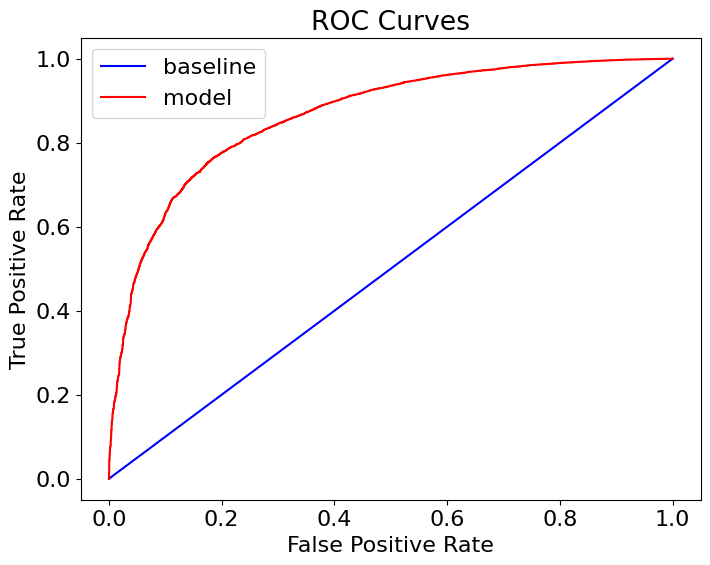

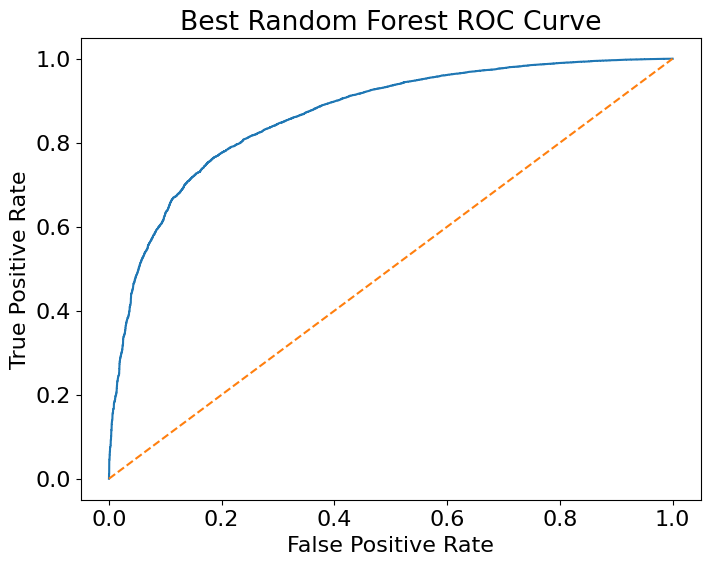

In [33]:
from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score

evaluate_model(preds, probs, train_preds, train_probs)

fpr, tpr, _ = roc_curve(test_labels, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Best Random Forest ROC Curve")
plt.show()


### Confusion Matrix Helper function

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 1304  4270]
 [  332 24017]]


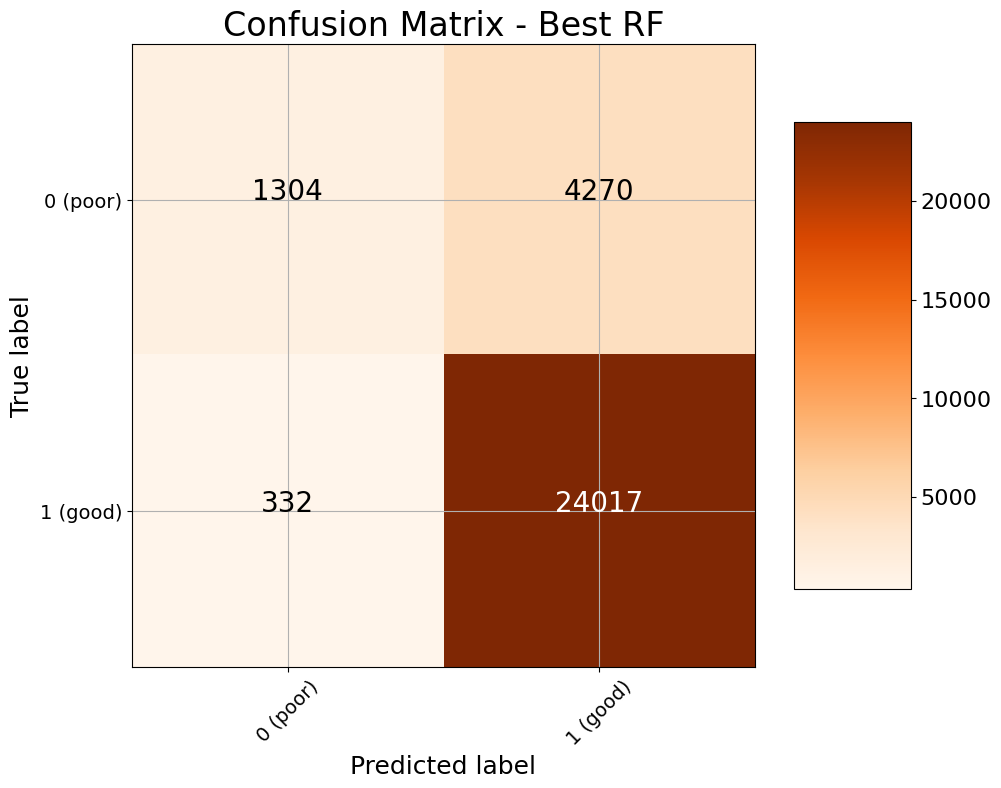

In [35]:
cm = confusion_matrix(test_labels, preds)
plot_confusion_matrix(cm, classes=["0 (poor)", "1 (good)"], normalize=False, title="Confusion Matrix - Best RF")
plt.show()


### Observations / Insights ???

In [36]:
print("""
Observations / Insights:
1) Label is imbalanced (more 1s than 0s). ROC AUC is a good metric here vs accuracy alone.
2) RandomizedSearchCV finds non-default hyperparameters that generally improve ROC AUC over a default RF.
3) Compare train vs test ROC AUC:
   - If train >> test, the model may be overfitting (too deep / too many nodes).
   - If close, generalization is better.
4) Confusion matrix shows whether the model is missing too many '0 (poor health)' cases.
   If recall for class 0 is low, consider class_weight='balanced' or threshold tuning.
""")



Observations / Insights:
1) Label is imbalanced (more 1s than 0s). ROC AUC is a good metric here vs accuracy alone.
2) RandomizedSearchCV finds non-default hyperparameters that generally improve ROC AUC over a default RF.
3) Compare train vs test ROC AUC:
   - If train >> test, the model may be overfitting (too deep / too many nodes).
   - If close, generalization is better.
4) Confusion matrix shows whether the model is missing too many '0 (poor health)' cases.
   If recall for class 0 is low, consider class_weight='balanced' or threshold tuning.



### Bonus: What if you want to explain your best RandomForest to your boss on the way it split the features??? Do not fret. Capture the estimator and convert them into a .png and present it in the meeting and get accolodes.

In [42]:
import os
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ["PATH"]


In [43]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

estimator = best_model.estimators_[1]

# Export a tree from the forest
export_graphviz(estimator, 'tree_from_optimized_forest.dot', rounded = True, 
                feature_names=train.columns, max_depth = 8, 
                class_names = ['poverty', 'no poverty'], filled = True)

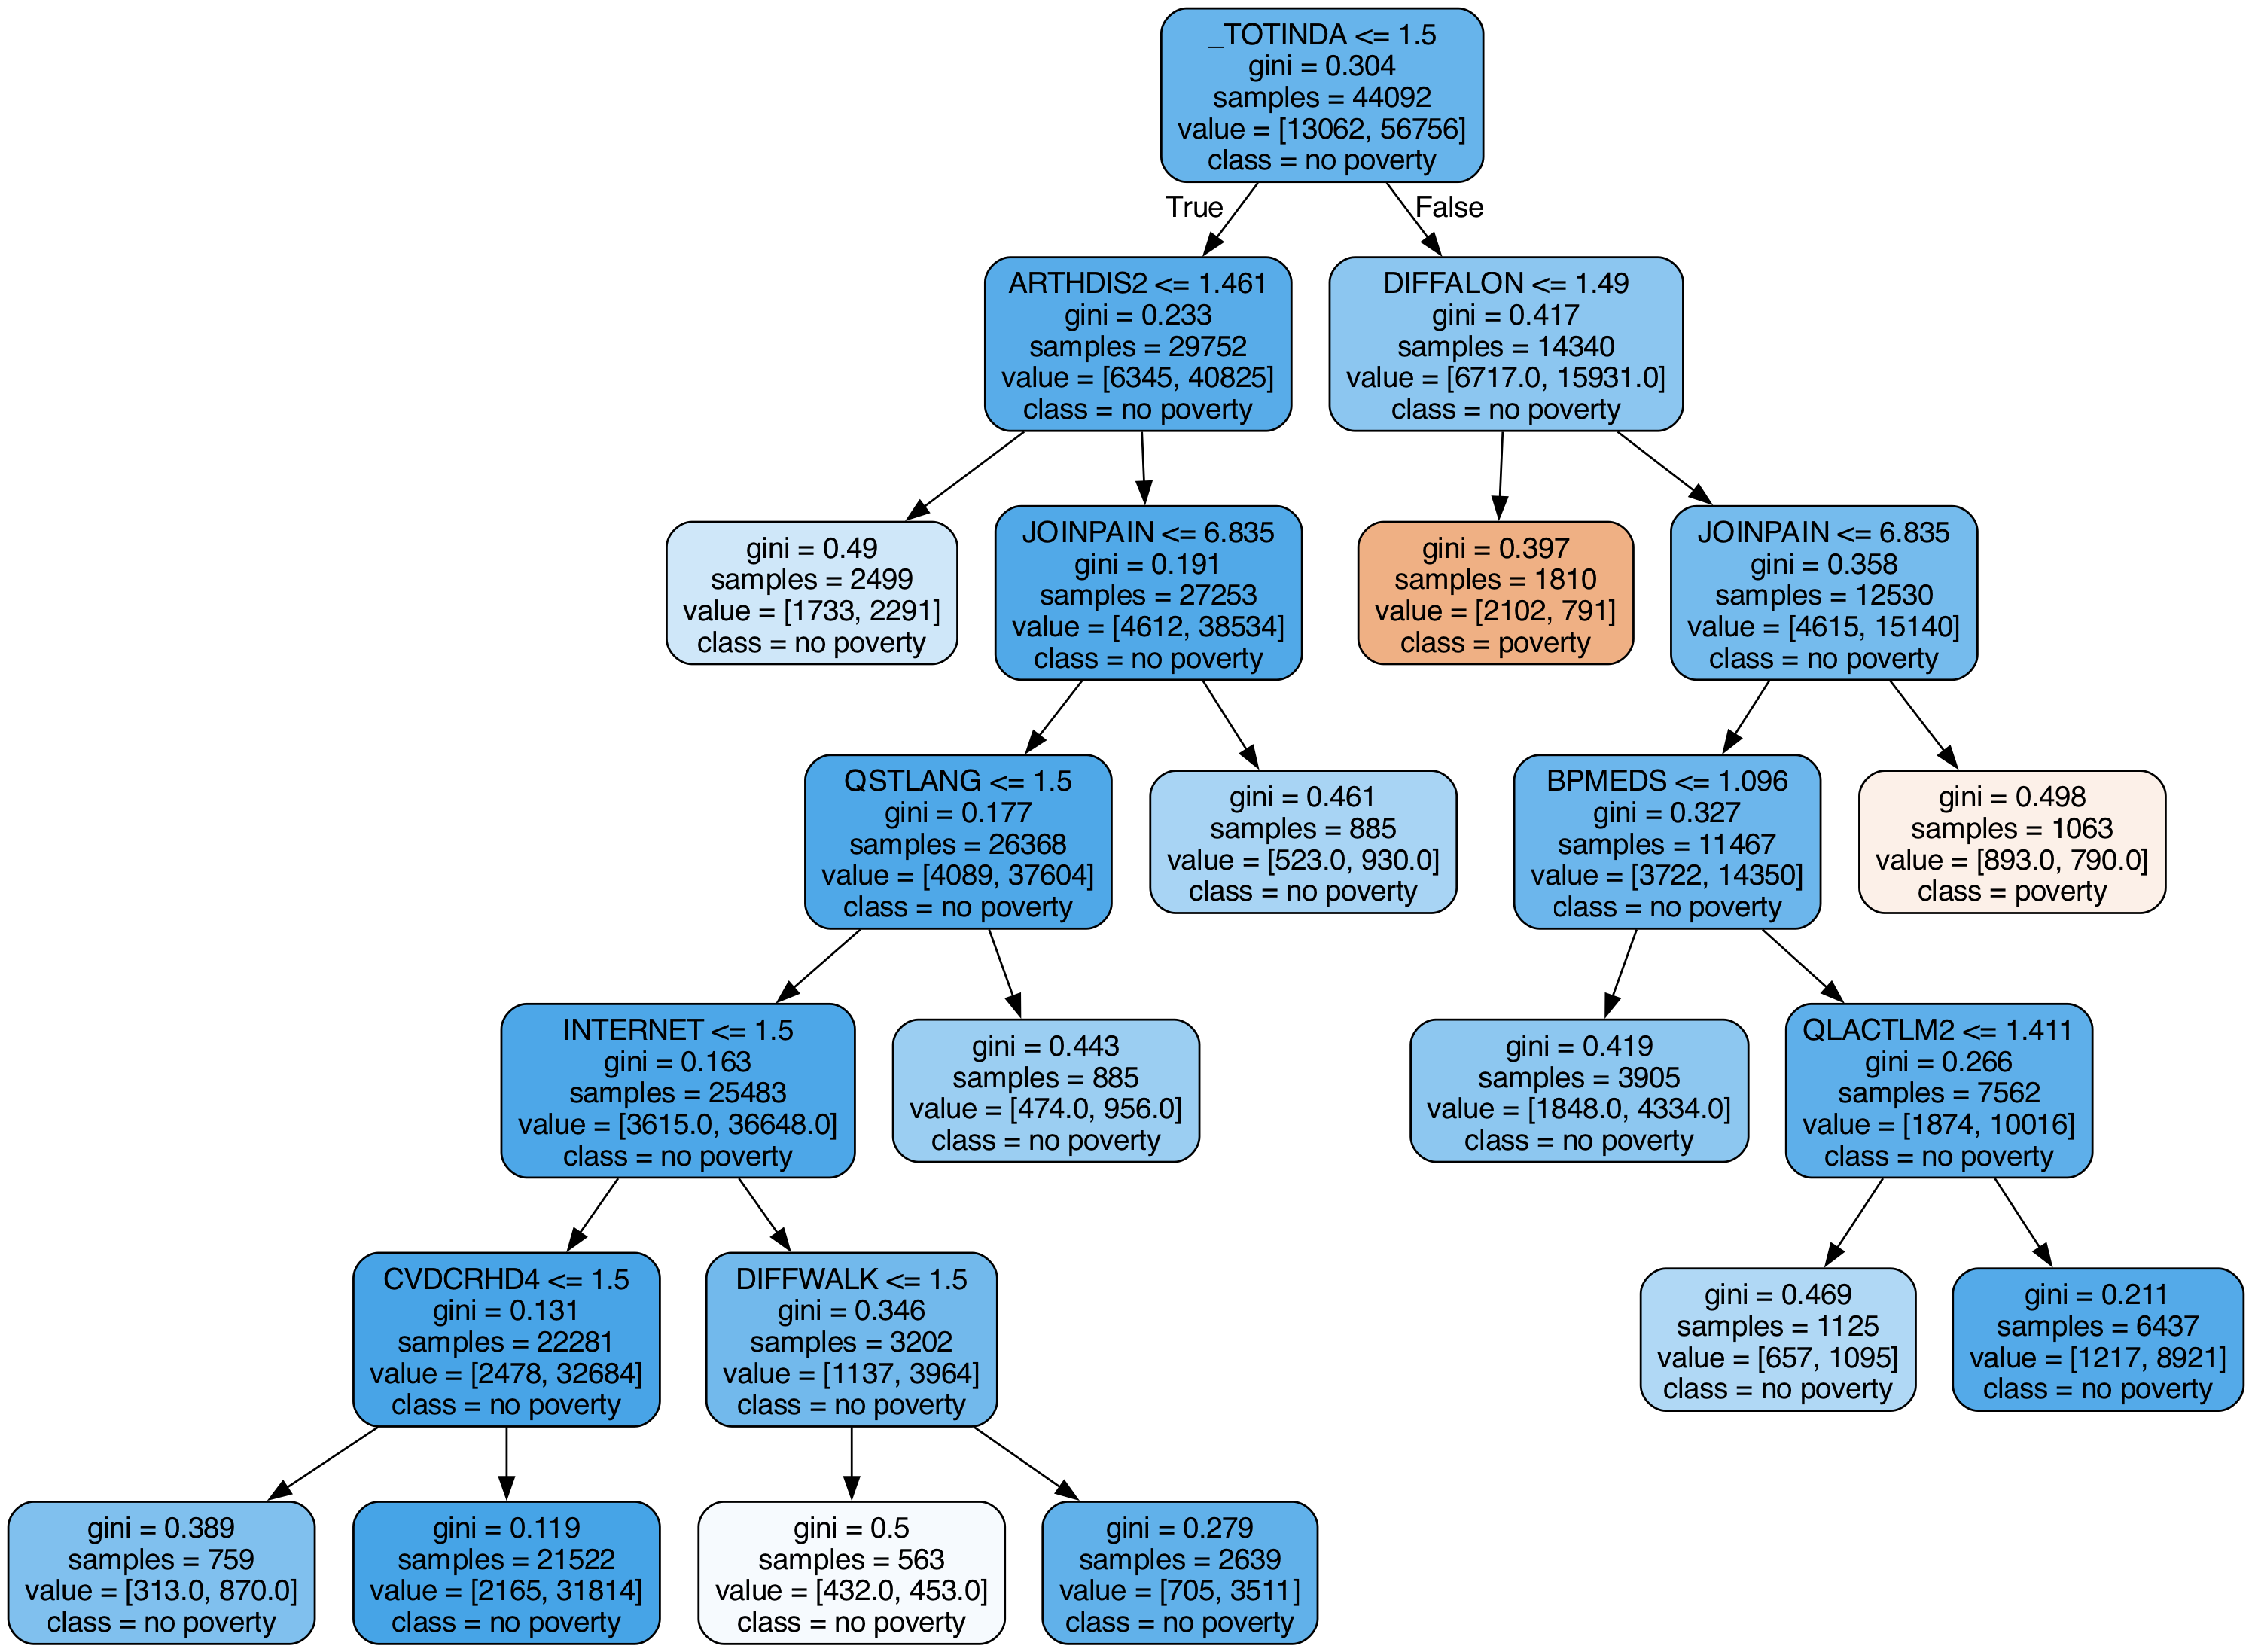

In [44]:
call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])
Image('tree_from_optimized_forest.png')